In [1]:
import os
import glob
import sys

import common as com
import numpy
import tqdm
import sklearn
import torch
from train import list_to_vector_array
from train import file_list_generator
from train import AutoEncoder
from train import fetch_dataloaders
import torch.nn as nn

In [8]:
########################################################################
# visualizer
########################################################################
class Visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        #设置y轴范围
        #self.plt.ylim(-5,100)
        ax.set_title("batch loss")
        ax.set_xlabel("batch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Validation"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save png file path.
        return : None
        """
        self.plt.savefig(name)


########################################################################


In [47]:
param = com.yaml_load()
def test(dir,save):
    ab_dir = '../file/noise_detect'
    ab_files = file_list_generator(ab_dir, dir_name=dir)
    com.logger.info('files num {num}'.format(num=len(ab_files)))
    ab_data = list_to_vector_array(ab_files,
                                      msg="generate train_dataset",
                                      n_mels=param["feature"]["n_mels"],
                                      frames=param["feature"]["frames"],
                                      n_fft=param["feature"]["n_fft"],
                                      hop_length=param["feature"]["hop_length"],
                                      power=param["feature"]["power"])
    ab_data = torch.Tensor(ab_data)
    com.logger.info('train_data num {num}'.format(num=len(ab_data)))
    ab_loader = torch.utils.data.DataLoader(dataset=ab_data, batch_size=512, shuffle=True)
    model = torch.load('model/model.pkl')
    loss_func = nn.MSELoss()
    features = []
    losses = []
    for data in ab_loader:
        inputs = data
        feature, y = model(inputs)
        loss = loss_func(y, inputs)
        for one_feature in feature:
            features.append(list(one_feature))
        losses.append(loss)
    #numpy.save('../file/noise_detect/feature/'+save,numpy.array(features))
    return features,losses

ab_feature,ab_loss = test('test/abnormal','abnormal_feature')
normal_feature,normal_loss = test('test/normal','normal_feature')


2021-10-13 22:55:36,296 - INFO - target_dir : ../file/noise_detect
2021-10-13 22:55:36,297 - INFO - train_file num : 4
2021-10-13 22:55:36,299 - INFO - files num 4
generate train_dataset: 100%|██████████| 4/4 [00:00<00:00, 76.86it/s]
2021-10-13 22:55:36,356 - INFO - train_data num 2488
2021-10-13 22:55:37,633 - INFO - target_dir : ../file/noise_detect
2021-10-13 22:55:37,634 - INFO - train_file num : 44
2021-10-13 22:55:37,635 - INFO - files num 44
generate train_dataset: 100%|██████████| 44/44 [00:00<00:00, 76.64it/s]
2021-10-13 22:55:38,226 - INFO - train_data num 27368


In [48]:
visualizer = Visualizer()
visualizer.loss_plot(ab_loss)
visualizer.save_figure('ab_loss.png')
visualizer.loss_plot(normal_loss)
visualizer.save_figure('normal_loss.png')

C:\ZTTTX\Programing\Anaconda\envs\noise_detect\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    colors = {0:'r',1:'b'}
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], '.',
                 color=colors[int(label[i])],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

tsne = TSNE(n_components=2, init='pca', random_state=0)
zero = torch.zeros(len(ab_feature))
one = torch.ones(len(normal_feature))
label = torch.cat((zero,one),0)
feature = ab_feature + normal_feature
print(len(feature))
print(len(label))



29856
29856


In [50]:
result = tsne.fit_transform(feature[:5000])

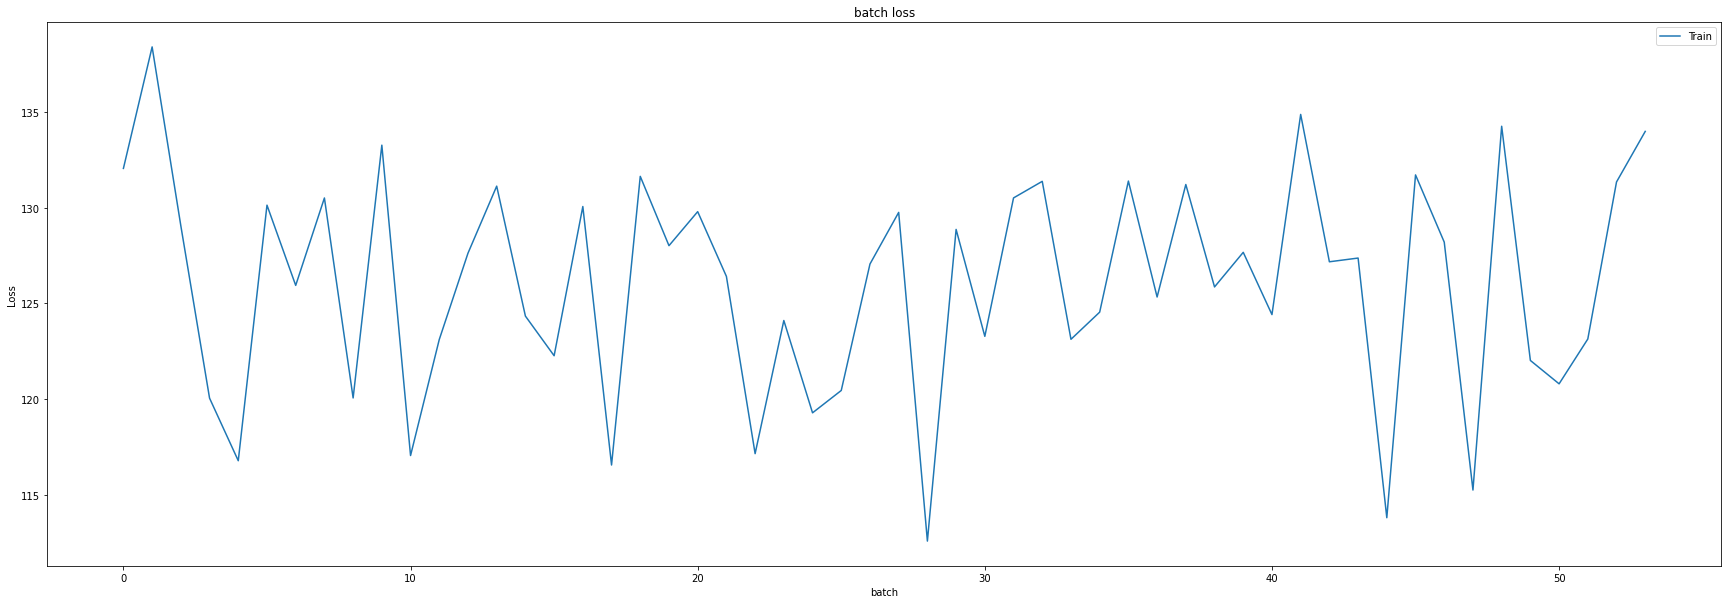

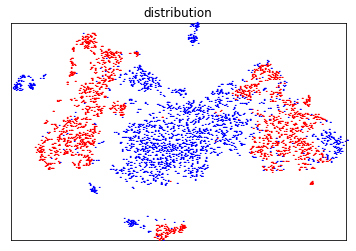

In [51]:
fig = plot_embedding(result[:5000], label[:5000],'distribution')
plt.show(fig)

In [52]:
result = tsne.fit_transform(feature)

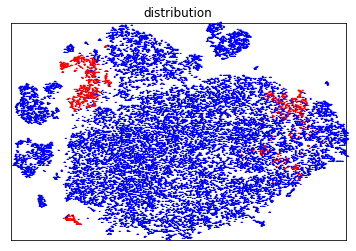

In [53]:
fig = plot_embedding(result, label,'distribution')
plt.savefig('distribution_all.png')
plt.show(fig)

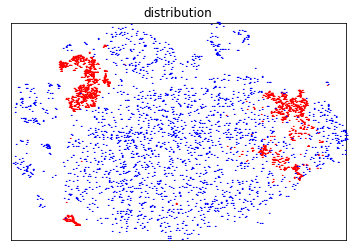

In [54]:
fig = plot_embedding(result[:5000], label[:5000],'distribution')
plt.savefig('distribution_all_5000.png')
plt.show(fig)